In [20]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [21]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
featurefolder = 'shadowtimes/'
features = None

In [22]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

In [27]:
trainY.head()

0    False
1     True
2     True
3    False
4    False
Name: Stable, dtype: bool

In [28]:
shadowstable = trainX['shadow_instability_time'] > 8.99e8

In [31]:
(trainY != shadowstable).sum()/trainY.shape[0]

0.029128641080135017

In [6]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [7]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.98299822                                          
ERROR                                               
0.002509070477674029                                
HOLDOUT SCORE                                       
0.9889651712425522                                  
SCORE:                                                                         
0.9826174200000001                                                             
ERROR                                                                          
0.0026067877021632184                                                          
HOLDOUT SCORE                                                                  
0.9875576287914012                                                             
SCORE:                                                                         
0.9826445600000001                                                             
ERROR                                     

SCORE:                                                                          
0.9826694400000001                                                              
ERROR                                                                           
0.002598995017552873                                                            
HOLDOUT SCORE                                                                   
0.9891007311365875                                                              
SCORE:                                                                          
0.98274298                                                                      
ERROR                                                                           
0.00248696973161242                                                             
HOLDOUT SCORE                                                                   
0.9890601898598665                                                              
SCORE:                      

In [8]:
best

{'x_learning_rate': 0.09521935569200246,
 'x_max_depth': 13,
 'x_min_child': 1.0,
 'x_pos_weight': 5.855193075447701,
 'x_subsample': 0.9860489356122553,
 'x_tree_colsample': 0.6952521974190764}

In [9]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.986522+0.000845665	test-auc:0.98307+0.00228606
[1]	train-auc:0.986794+0.000826441	test-auc:0.983464+0.0029306
[2]	train-auc:0.987046+0.000776667	test-auc:0.984141+0.00268236
[3]	train-auc:0.98711+0.000762618	test-auc:0.984289+0.00268119
[4]	train-auc:0.987178+0.000762871	test-auc:0.984329+0.00264988
[5]	train-auc:0.987239+0.000775802	test-auc:0.984246+0.00261636
[6]	train-auc:0.987323+0.000774171	test-auc:0.983871+0.00211961
[7]	train-auc:0.987527+0.000623706	test-auc:0.984185+0.00250583
[8]	train-auc:0.987705+0.000537867	test-auc:0.98357+0.00195941
[9]	train-auc:0.987677+0.000546166	test-auc:0.984224+0.00242325
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.986522       0.000846       0.983070      0.002286
1        0.986794       0.000826       0.983464      0.002931
2        0.987046       0.000777       0.984141      0.002682
3        0.987110       0.000763       0.984289      0.002681
4        0.987178       0.000763       0.984329      0

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [10]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6952521974190764, gamma=0,
       learning_rate=0.09521935569200246, max_delta_step=0, max_depth=13,
       min_child_weight=1.0, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=5.855193075447701,
       seed=None, silent=True, subsample=0.9860489356122553)

Text(0.5, 1.0, 'ROC curve (AUC = 0.988)')

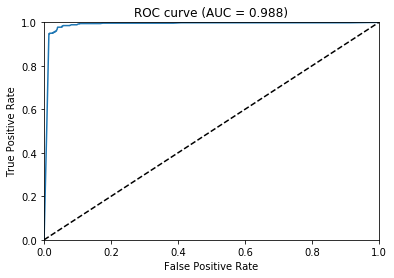

In [11]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [12]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.0006096069701015949, recall = 1.0, precision = 0.2705
Threshold 0.00089863600442186, recall = 0.9981515711645101, precision = 0.3486120077469335
Threshold 0.0012281775707378983, recall = 0.9981515711645101, precision = 0.4047976011994003
Threshold 0.001919612055644393, recall = 0.9963031423290203, precision = 0.4895549500454133
Threshold 0.002740290015935898, recall = 0.9963031423290203, precision = 0.5094517958412098
Threshold 0.003791387192904949, recall = 0.9963031423290203, precision = 0.5602910602910602
Threshold 0.0047541395761072636, recall = 0.9963031423290203, precision = 0.6145952109464082
Threshold 0.005252937786281109, recall = 0.9963031423290203, precision = 0.6431980906921241
Threshold 0.007920544594526291, recall = 0.9944547134935305, precision = 0.6888604353393086
Threshold 0.009819339960813522, recall = 0.9944547134935305, precision = 0.7231182795698925
Threshold 0.016024379059672356, recall = 0.9944547134935305, precision = 0.7609618104667609
Threshold 0.0

IndexError: index 255 is out of bounds for axis 0 with size 255

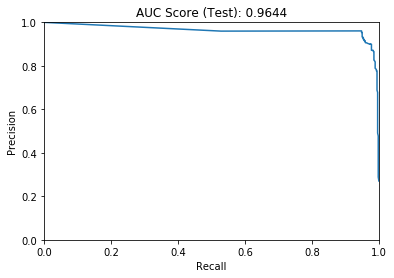

In [13]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 564.3000000000001)

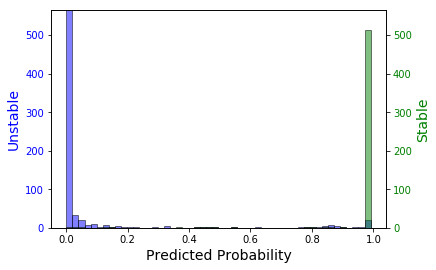

In [14]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

../modelfitting.py:79: RuntimeWarning: divide by zero encountered in true_divide
  errorbars.append(np.sqrt(1./nstable + 1./hist[i])*fracstable[-1]) # assume poisson counting errors for each fractional error, and add in quadrature for error on ratio.
../modelfitting.py:79: RuntimeWarning: invalid value encountered in double_scalars
  errorbars.append(np.sqrt(1./nstable + 1./hist[i])*fracstable[-1]) # assume poisson counting errors for each fractional error, and add in quadrature for error on ratio.


Text(0, 0.5, 'Fraction actually stable')

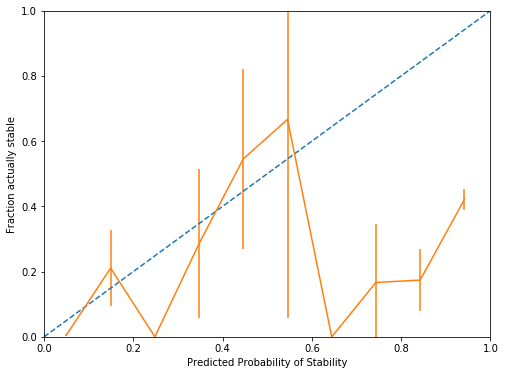

In [15]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

../modelfitting.py:107: RuntimeWarning: divide by zero encountered in true_divide
  errorbars.append(np.sqrt(1./Nerrors + 1./hist[i])*errorfracs[-1]) # see calibration plot comment
../modelfitting.py:107: RuntimeWarning: invalid value encountered in double_scalars
  errorbars.append(np.sqrt(1./Nerrors + 1./hist[i])*errorfracs[-1]) # see calibration plot comment


Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

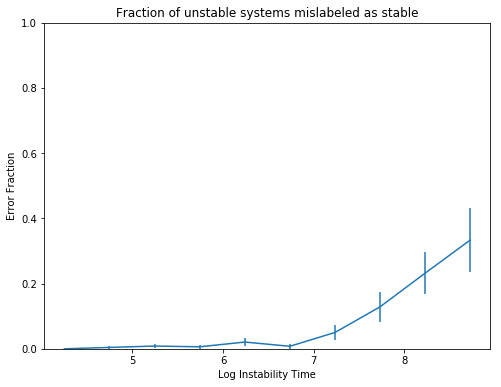

In [16]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

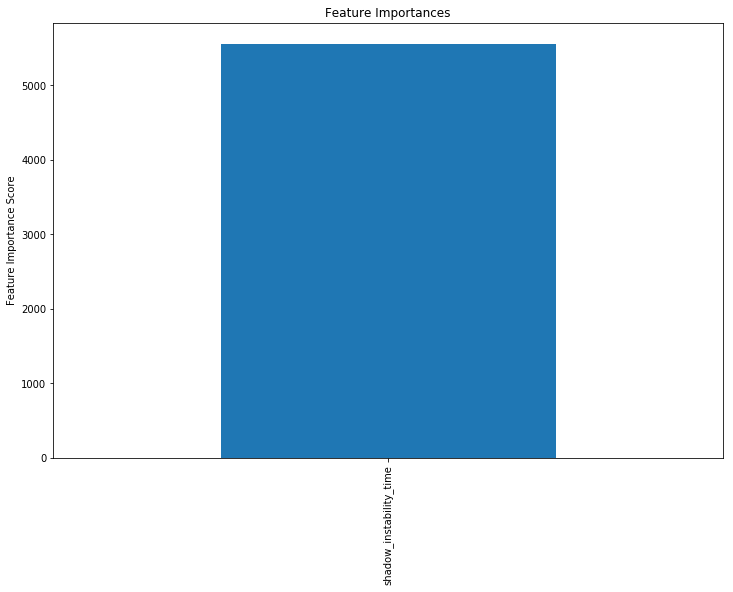

In [17]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [19]:
dill.dump([model, features, featurefolder], open(datapath+"../models/shadowtimesxgb_resonant.pkl", "wb"))